In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import cellregulondb as crdb

## Load

In [2]:
df = pd.read_csv("../../tests/test_data/ionocyte_regulons.csv", index_col=0)

In [3]:
ra = crdb.RegulonAtlas()

In [4]:
ra.load_from_df(df)

/Users/jp30/Documents/projects/cellregulondb/cellregulondb/regulonatlas.py:95: UserWarning: Column 'celltype' not found in `self.adata.obs`. Available columns: ['transcription_factor', 'regulation', 'tissue', 'cell_type', 'author_cell_type', 'rss', 'n_genes'], set `self.cell_type_col` to the correct column name.
  warnings.warn(


In [5]:
ra.cell_type_col = "cell_type"

## Filter

In [6]:
regulons = ra.find_regulons(transcription_factors=['FOXI1', 'RFX2', 'KLF5'])

In [7]:
ra_sub = ra.subset(regulons=regulons.index.tolist())

In [8]:
ra_sub

RegulonAtlas object with 30 regulons, 1 cell types and 425 target genes.

In [9]:
G1 = ra_sub.to_networkx(min_regulon=3, min_degree_targets=2, subset="regulation == '+'")
G2 = ra_sub.to_networkx(min_regulon=3, min_degree_targets=2, subset="regulation == '-'")
G = nx.compose(G1, G2)

In [10]:
print(G)

DiGraph with 13 nodes and 22 edges


## Plot

simple plotting through networkx

In [11]:
# customise edge colors and labels
edge_cols = []
edge_labs = {}
for edge in G.edges:
    if edge in G1.edges and edge in G2.edges:
        edge_cols.append('black')
        edge_labs[edge] = "(+/-)"
    elif edge in G1.edges:
        edge_cols.append('cornflowerblue')
        edge_labs[edge] = "(+)"
    elif edge in G1.edges:
        edge_cols.append('coral')
        edge_labs[edge] = "(-)"

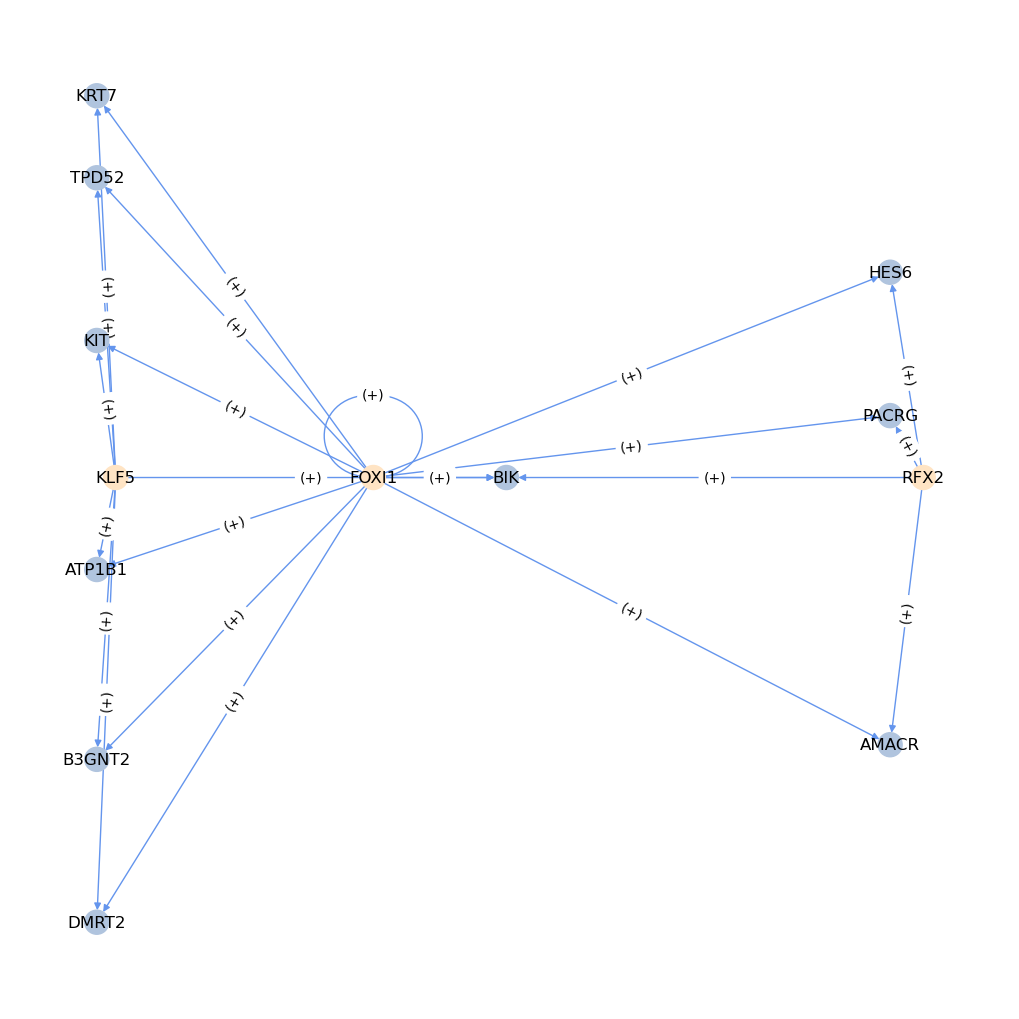

In [12]:
_ = crdb.util.plot_networkx(G, show=True, layout='spectral', edge_label_kwargs=dict(edge_labels=edge_labs), edge_color = edge_cols)

## Export to Cytoscape

for interactive visualisation

In [13]:
lnk_df, reg_df, trg_df = ra_sub.get_tables(by="transcription_factor")

In [14]:
lnk_df.head()

,source,target,regulation,tissue,cell_type,author_cell_type,rss,n_genes
0,FOXI1,ACTB,[-],[saliva-secreting gland],[ionocyte],[Ionocytes],[0.1674971418885932],[21]
1,FOXI1,ACVR1,[+],[saliva-secreting gland],[ionocyte],[ionocyte],[0.1802618916913065],[66]
2,FOXI1,ADCY5,"[+, +, +]","[nose, respiratory airway, trachea]","[ionocyte, ionocyte, ionocyte]","[ionocyte, ionocyte, ionocyte]","[0.1736063804938967, 0.1759994083843268, 0.169...","[82, 82, 57]"
3,FOXI1,ADGRF5,"[+, +]","[lung parenchyma, nose]","[ionocyte, ionocyte]","[ionocyte, ionocyte]","[0.1696202036159126, 0.1736063804938967]","[34, 82]"
4,FOXI1,ADGRG2,[+],[respiratory airway],[ionocyte],[ionocyte],[0.1759994083843268],[82]


In [15]:
reg_df.head()

,source,transcription_factor
0,FOXI1,"[FOXI1, FOXI1, FOXI1, FOXI1, FOXI1, FOXI1, FOX..."
1,KLF5,"[KLF5, KLF5, KLF5, KLF5, KLF5, KLF5, KLF5, KLF..."
2,RFX2,"[RFX2, RFX2, RFX2, RFX2, RFX2, RFX2, RFX2, RFX..."


In [16]:
trg_df.head()

,target
0,ACAA2
1,ACAT2
2,ACTB
3,ACTR3B
4,ACTR3C


save tables to files

In [17]:
# lnk_df.to_csv("~/Downloads/links.tsv", sep="\t")

the other two dataframes do not contain any relevant information here, but could be used to add node attributes, when importing the network:

In [18]:
# reg_df.to_csv("~/Downloads/regs.tsv", sep="\t")
# trg_df.to_csv("~/Downloads/trgs.tsv", sep="\t")

The table can be imported in an interactive visualisation program

E.g. for Cytoscape:
1. "File" > "Import" > "Network from File" > "link.tsv"
  - (for additional node attributes: "File" > "Import" > "Table from File" > "regs.tsv")

To recreate the above figure by creating corresponding filters, e.g.:
1. filter out nodes with indegree < 2 and outdegree == 0
2. select edges that match regex `.*([+-].*){3}` for regulation column
3. arrange nodes

This results in the following plot
![network in Cytoscape](links.png)

Of course the above tables can be first preprocessed further in python.
A reasonable processing step would be to convert the list attributes into sets, or perform majority voting on them.

In [19]:
# save number of regulons first, before this information is lost
lnk_df["n_regulon"] = lnk_df["regulation"].apply(len)

In [20]:
for col in ['cell_type', 'tissue', 'regulation']:
    lnk_df[col] = lnk_df[col].apply(set)

In [21]:
lnk_df

,source,target,regulation,tissue,cell_type,author_cell_type,rss,n_genes,n_regulon
0,FOXI1,ACTB,{-},{saliva-secreting gland},{ionocyte},[Ionocytes],[0.1674971418885932],[21],1
1,FOXI1,ACVR1,{+},{saliva-secreting gland},{ionocyte},[ionocyte],[0.1802618916913065],[66],1
2,FOXI1,ADCY5,{+},"{nose, respiratory airway, trachea}",{ionocyte},"[ionocyte, ionocyte, ionocyte]","[0.1736063804938967, 0.1759994083843268, 0.169...","[82, 82, 57]",3
3,FOXI1,ADGRF5,{+},"{lung parenchyma, nose}",{ionocyte},"[ionocyte, ionocyte]","[0.1696202036159126, 0.1736063804938967]","[34, 82]",2
4,FOXI1,ADGRG2,{+},{respiratory airway},{ionocyte},[ionocyte],[0.1759994083843268],[82],1
...,...,...,...,...,...,...,...,...,...
529,RFX2,TM7SF2,{+},{lung parenchyma},{ionocyte},[ionocyte],[0.1675555728367578],[33],1
530,RFX2,TSPAN6,{+},{trachea},{ionocyte},[ionocyte],[0.1676191161975324],[16],1
531,RFX2,TUSC3,{+},{trachea},{ionocyte},[ionocyte],[0.1676191161975324],[16],1
532,RFX2,WLS,{+},{lung parenchyma},{ionocyte},[ionocyte],[0.1675555728367578],[33],1
